<a href="https://colab.research.google.com/github/prithwis/AGI/blob/main/TaxiV3_v7_abandoned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![CC-BY-SA](https://licensebuttons.net/l/by-sa/3.0/88x31.png)<br>


![alt text](https://github.com/Praxis-QR/RDWH/raw/main/images/YantraJaalBanner.png)<br>




[Prithwis Mukerjee](http://www.linkedin.com/in/prithwis)<br>

#Bigger Grid / Abandoned
for simulating Reinforcement Learning Applications

In [1]:
# 1. Update package list and install the NEW opengl names
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb ffmpeg freeglut3-dev python3-opengl libgl1-mesa-dev libglu1-mesa-dev mesa-utils > /dev/null 2>&1

# 2. Install the system dependencies (SWIG is the key here)
#!apt-get update
!apt-get install -y swig build-essential python3-dev > /dev/null 2>&1

# 3. Upgrade pip and setuptools to handle the build process better
!pip install --upgrade pip setuptools wheel > /dev/null 2>&1

# 4. Now install gymnasium with box2d support
!pip install "gymnasium[box2d]" > /dev/null 2>&1

# 5. Install the Python libraries
!pip install pyvirtualdisplay  pygame opencv-python > /dev/null 2>&1


In [2]:
import pygame
import cv2
import numpy as np
import os

from IPython.display import Video, display


/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.12.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# --- 1. THE RECORDER CLASS ---
class VideoRecorder:
    def __init__(self, filename='simulation.avi', width=640, height=480, fps=30):
        self.filename = filename
        self.width = width
        self.height = height
        self.fps = fps
        self.fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.video_writer = None

    def start(self):
        if os.path.exists(self.filename): os.remove(self.filename)
        self.video_writer = cv2.VideoWriter(self.filename, self.fourcc, self.fps, (self.width, self.height))


    def record_frame_with_hud(self, frame_array, reward, step):
        # 1. Convert RGB to BGR for OpenCV
        view = cv2.cvtColor(frame_array, cv2.COLOR_RGB2BGR)
        view = cv2.resize(view, (self.width, self.height))

        # 2. Add text overlay (The HUD)
        font = cv2.FONT_HERSHEY_SIMPLEX
        # Display Step and Reward
        cv2.putText(view, f"Step: {step}", (10, 30), font, 0.7, (255, 255, 255), 2)
        cv2.putText(view, f"Reward: {reward}", (10, 60), font, 0.7, (255, 255, 255), 2)
        self.video_writer.write(view)

    def stop(self):
        self.video_writer.release()
        # Convert to MP4 for browser compatibility
        output_mp4 = self.filename.replace('.avi', '.mp4')
        os.system(f"ffmpeg -y -i {self.filename} -c:v libx264 -pix_fmt yuv420p {output_mp4} -hide_banner -loglevel error")
        return output_mp4

In [12]:
import gymnasium as gym
import numpy as np

# 1. Design your 7x7 Mars Map
# S = Start, G = Goal, H = Hole (Crater), F = Frozen (Flat ground)
mars_map = [
    "SFFFFF|",
    "F|F|F|F",
    "F|F|F|F",
    "FF|F|FF",
    "F|F|F|F",
    "F|F|G|F",
    "FFFFFFB" # B is just a marker, we use 'F' for flat
]

# 2. Create the environment
# is_slippery=False makes it deterministic (like the Taxi)
env = gym.make('FrozenLake-v1', desc=mars_map, is_slippery=False, render_mode="rgb_array")

# 3. Initialize the Brain
# State space is exactly 49 (7x7)
q_table = np.zeros([env.observation_space.n, env.action_space.n])

print(f"✅ Success! Mars Grid initialized.")
print(f"Grid Size: 7x7 | Total States: {env.observation_space.n}")

✅ Success! Mars Grid initialized.
Grid Size: 7x7 | Total States: 49


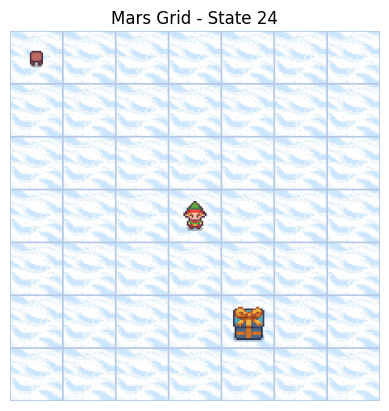

In [13]:
import matplotlib.pyplot as plt

# 1. Reset the environment
state, info = env.reset()

# 2. Teleport to a specific spot (e.g., State 24 is roughly the center)
env.unwrapped.s = 24

# 3. Render and Display
frame = env.render()
plt.imshow(frame)
plt.axis('off')
plt.title(f"Mars Grid - State {env.unwrapped.s}")
plt.show()

In [14]:
import random

# Hyperparameters
alpha = 0.1    # Learning rate
gamma = 0.99   # Discount factor (long-term thinking)
epsilon = 1.0  # Exploration rate (start at 100% random)
decay = 0.001  # How fast to stop being random
episodes = 2000

# Training
for i in range(episodes):
    state, _ = env.reset()
    terminated = False
    truncated = False

    while not (terminated or truncated):
        # Epsilon-greedy: Choose random action or best known action
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])

        next_state, reward, terminated, truncated, _ = env.step(action)

        # Adjust reward: Give a small penalty for every move to find the SHORTEST path
        if not terminated:
            reward = -0.1
        elif reward == 0: # If it hit a 'H' (Crater), it gets 0 reward by default
            reward = -5   # Give it a bigger penalty for crashing
        else:
            reward = 10   # Reached the Goal!

        # Q-Table Update Math
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        # New Q-Value formula
        q_table[state, action] = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)

        state = next_state

    # Decay the exploration rate
    epsilon = max(0.1, epsilon - decay)

print("Training Complete!")



Training Complete!


In [ ]:
# Execute training
trained_brain = train_taxi(10000)

Training complete.


In [21]:
# Assuming your original VideoRecorder class is already in memory.
# If not, ensure it has the .record_frame_with_hud() and .stop() methods.

# 1. Initialize the recorder for the 7x7 Grid
recorder = VideoRecorder(filename='mars_navigator_7x7.mp4', fps=8)
recorder.start()

# 2. Reset the Environment
state, _ = env.reset()
terminated = False
truncated = False
total_reward = 0
step_count = 0
action_names = ["Left", "Down", "Right", "Up"]

print("🚀 Commencing Mars 7x7 Navigation...")

# 3. The Recording Loop
while not (terminated or truncated):
    # Select the best action from your trained 7x7 Q-Table
    action = np.argmax(q_table[state])

    # Grab the current frame
    frame = env.render()

    # Use the OLD recorder to snap the frame
    # We'll pass the state index and the action name to the HUD
    hud_info = f"Step: {step_count} | State: {state} | Action: {action_names[action]}"
    recorder.record_frame_with_hud(frame, total_reward, hud_info)

    # Move the agent
    state, reward, terminated, truncated, _ = env.step(action)
    total_reward += reward
    step_count += 1

# 4. Final Frame & Cleanup
final_frame = env.render()
recorder.record_frame_with_hud(final_frame, total_reward, "MISSION COMPLETE")
recorder.stop()

print(f"✅ Video saved to: {recorder.filename}")

🚀 Commencing Mars 7x7 Navigation...
✅ Video saved to: mars_navigator_7x7.mp4


In [22]:
import os
from IPython.display import HTML
from base64 import b64encode

def show_video(file_name):
    # This 'processed' filename is for the web-compatible version
    processed_file = "processed_" + file_name

    # 1. Use ffmpeg to convert the video to H.264 (the web standard)
    # The -y flag overwrites if the file already exists
    os.system(f"ffmpeg -i {file_name} -vcodec libx264 -y {processed_file} -loglevel quiet")

    # 2. Read the newly processed file
    mp4 = open(processed_file, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

    return HTML(f'''
    <video width="400" controls>
        <source src="{data_url}" type="video/mp4">
    </video>
    ''')

# Now try playing your file again
show_video('mars_navigator_7x7.mp4')

#Chronobooks <br>
Three science fiction novels by Prithwis Mukerjee. A dystopian Earth. A technocratic society managed by artificial intelligence. Escape and epiphany on Mars. Can man and machine, carbon and silicon explore and escape into other dimensions of existence? An Indic perspective rooted in Advaita Vedanta and the Divine Feminine.  [More information](http://bit.ly/chrono3) <br>
![alt text](https://blogger.googleusercontent.com/img/a/AVvXsEjsZufX_KYaLwAnJP6bUxvDg5RSPn6r8HIZe749nLWX3RuwyshrYEAUpdw03a9WIWRdnzA9epwJOE05eDJ0Ad7kGyfWiUrC2vNuOskb2jA-e8aOZSx8YqzT8mfZi3E4X1Rz3qlEAiv-aTxlCM976BEeTjx4J64ctY3C_FoV4v9aY_U23F8xRqI5Eg=s1600)